In [1]:
from miditok import REMI, get_midi_programs
from miditoolkit import MidiFile
from pathlib import Path
import numpy as np

# find usually how many events between two bars

In [2]:
def find_events_between_bar(events):
    count_list = []
    position = 0
    count = 0
    num_events = 0
    for i in np.arange(len(events)):
        if events[position] == 1:
            if count <= 1:
                position += 1
                continue
            else:
                count_list.append(count)
                count = 0
                position += 1
                num_events += 1
                continue
        position += 1
        count += 1
    return count_list, num_events
                
        

## Pop music

In [81]:
count_list,num_events = find_events_between_bar(val1[20])

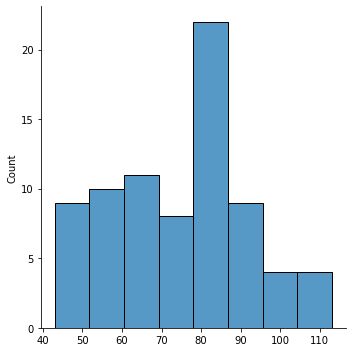

In [82]:
import seaborn as sns
sns.displot(count_list)

In [83]:
print("Num of events: ", num_events)

Num of events:  77


In [84]:
print("Length: ", len(val1[20]))

Length:  5832


I already converted all the events for each song into a json file. Now I extract them and create a npy for each of them with variable number of rows and fixed number of columns (representing a sequence)

# read JSON files and extract the events for the dataset

In [2]:
import json
import os
from tqdm.auto import tqdm

def extract_events_folder(subfolder):
    folder = "Pop-music-REMI/" + subfolder
    filenames = os.listdir(folder)
    fullnames = list(map(lambda name: os.path.join(folder,name), filenames))

    progress = tqdm(range(len(fullnames)))
    tokens = []
    
    for name in fullnames:
        if name == folder + "\config.txt":
            progress.update(1)
            continue
        else:
            f = open(name)
            #print(name)
            a = json.load(f)
            #print(a)
            events = a[0][0]
            tokens.append(events)
            progress.update(1)
    print("converted files: ", len(tokens))
    return tokens



# convert tokens to subset of tokens with length 2000 with gap 50

To make sure that everything in between are events, will search for the first bar event from the beginning, then pad everything before with 0, for sequence between the music, search for the bar event from the end backward, and pad everything from that event until the end with 0, for ending the sequence, don't do that

In [4]:
def find_bars(events,finish):
    seq_len = len(events)
    # find the next bar from beginning, and pad everything before
    position = 0
    for i in np.arange(seq_len):
        if events[position] == 1:
            break
        else:
            events[position] = 0
            position += 1
    #print("next bar event position: ", position)
    
    # if this is the sequence represent an end of a song, return events
    if finish:
        return events
    
    # find the previous bar event from the end, and pad everyting after
    position = seq_len -1
    for i in np.arange(position,0,-1):
        if events[position] == 1:
            events[position] = 0
            #print("previous bar event position: ", position)
            return events
        else:
            events[position] = 0
            position -= 1
    


In [6]:
def find_last_bar(position,events):
    while events[position] != 1:
        position -= 1
    return position

In [9]:
a = [1,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,1,2,2,2]
b = find_last_bar(19,a)
b

19

In [3]:
def convert(events,index,seq_len=2000,segment_every=50):
    # if the sequence length is less than 2000, pad the sequence until 2000 and return it
    if len(events) <= seq_len:
        #print(len(events))
        events = np.pad(events,(0,seq_len - len(events)))
        #print(len(events))
        return [1]
    
    output_tokens = []
    
    # if I have events of length 5 and seq_len of 3
    #  the final position is 2 and the final sequence is in position 2, 3, 4
    final_position = len(events) - seq_len # this is the start point of the last sample
    
    i=0
    
    while i <= final_position:
        # if current sequence is not the end of the song
        tokens = events[i:i+seq_len] 
        assert len(tokens) == seq_len
        
        # pad the beginning and the end so that the whole sequence represent whole events
        #tokens = find_bars(tokens,False)
        #assert len(tokens) == seq_len
        
        output_tokens.append(tokens)
        
        i += segment_every # move seq_len away, so starting a new sequence but from a bar event
        
        
        
        
        # if the next sequence reaches the end of the music
        if i >= final_position:
            tokens = events[final_position:final_position+seq_len]
            
            assert len(tokens) == seq_len
            
            # pad the tokens
            #tokens = find_bars(tokens,True)
            #assert len(tokens) == seq_len
            
            output_tokens.append(tokens)
        
            break
    
    output_tokens = np.array(output_tokens)
    #print(output_tokens.shape)
    #np.save(output_path+str(index)+".npy",output_tokens)
    return output_tokens
    
    
    
    

In [29]:
a = np.zeros(10)
b = np.array([1,2,3])
c = np.pad(b,(0,10-len(b)))
print(c)
print(len(c))

[1 2 3 0 0 0 0 0 0 0]
10


# convert a folder

In [4]:
def convert_folder(subfolder,output_path,seq_len=2000,segment_every=50):
    event_list = extract_events_folder(subfolder)
    num_items = len(event_list)
    progress = tqdm(range(num_items))
    converted_events = convert(event_list[0], 0, seq_len, segment_every)
    progress.update(1)
    assert converted_events.shape[1] == seq_len
    
    for i in np.arange(1,num_items):
        new_events = convert(event_list[i],i,seq_len,segment_every)
        if len(new_events) == 1:
            progress.update(1)
            continue
        assert new_events.shape[1] == seq_len
        
        # concatenate new_events into converted_events list
        converted_events = np.concatenate((converted_events,new_events),axis=0)
        
        progress.update(1)
    
    print("final shape: ", converted_events.shape)
    np.save(output_path+subfolder+"800_every_100.npy", converted_events)

## training data

In [14]:
convert_folder("train","Customized Dataset - Pop/Train/",seq_len=800,segment_every=100)

  0%|          | 0/718 [00:00<?, ?it/s]

converted files:  718


  0%|          | 0/718 [00:00<?, ?it/s]

final shape:  (33011, 800)


In [16]:
convert_folder("train2","Customized Dataset - Pop/Train/",seq_len=800,segment_every=100)

  0%|          | 0/1604 [00:00<?, ?it/s]

converted files:  1604


  0%|          | 0/1604 [00:00<?, ?it/s]

final shape:  (65493, 800)


In [17]:
# concatenate the two training dataset
array1 = np.load("Customized Dataset - Pop/Train/train_800_every_100.npy")
array2 = np.load("Customized Dataset - Pop/Train/train2_800_every_100.npy")
array3 = np.concatenate((array1,array2),axis=0)
print("training sample size: ", array3.shape)
np.save("Customized Dataset - Pop/Train/customized_training_800_every_100.npy",array3)

training sample size:  (98504, 800)


## validation data

In [18]:
convert_folder("val","Customized Dataset - Pop/Val/",seq_len=800,segment_every=100)

  0%|          | 0/57 [00:00<?, ?it/s]

converted files:  57


  0%|          | 0/57 [00:00<?, ?it/s]

final shape:  (2768, 800)


In [19]:
convert_folder("val2","Customized Dataset - Pop/Val/",seq_len=800,segment_every=100)

  0%|          | 0/144 [00:00<?, ?it/s]

converted files:  144


  0%|          | 0/144 [00:00<?, ?it/s]

final shape:  (6458, 800)


In [20]:
# concatenate the two validation dataset
array1 = np.load("Customized Dataset - Pop/Val/val800_every_100.npy")
array2 = np.load("Customized Dataset - Pop/Val/val2800_every_100.npy")
array3 = np.concatenate((array1,array2),axis=0)
print("validation sample size: ", array3.shape)
np.save("Customized Dataset - Pop/Val/customized_val_800_every_100.npy",array3)

validation sample size:  (9226, 800)


# length 600 without padding
